# gppytorch

In [1]:
# install the latest version of discontinuum
# !pip install git+https://github.com/thodson-usgs/discontinuum.git
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

In [3]:
# setup

# SF Coeur D Alene River
site = "12413470"
start_date = "1988-10-01"
end_date = "2021-09-30"

# Choptank River at Greensboro, MD
# site = "01491000"
# start_date = "1979-10-01"
# start_date = "1993-10-01"
# end_date = "2011-09-30"

characteristic = "Inorganic nitrogen (nitrate and nitrite)"
# characteristic = 'Phosphorus'
fraction = "Dissolved"
# fraction = 'Total'

First, download the data. In `discontinuum`, the convention is to download directly using `providers`, which wrap a data provider's web-service and perform some initial formatting and metadata construction, then return the result as an `xarray.Dataset`. Here, we'll uses the `usgs` provider. If you need data from another source, create a `provider` and ensure the output matches that of the `usgs` provider. Here, we'll download some daily streamflow data to use as our model's input, and some concentration samples as our target. 

In [4]:
from loadest_gp.providers import usgs

# download covariates (daily streamflow)
daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)

# download target (concentration)
samples = usgs.get_samples(
    site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction
)

samples

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/providers/usgs.py:260: UserWarning: Censored values have been removed from the dataset.
  warnings.warn(


<xarray.Dataset> Size: 4kB
Dimensions:        (time: 227)
Coordinates:
  * time           (time) datetime64[ns] 2kB 1989-11-20T14:00:00 ... 2021-09-...
Data variables:
    concentration  (time) float64 2kB 0.29 0.1 0.3 0.2 ... 0.09 0.1 0.06 0.31
Attributes:
    id:         12413470
    name:       SF Coeur D Alene River nr Pinehurst, ID
    latitude:   47.5513111
    longitude:  -116.2362917

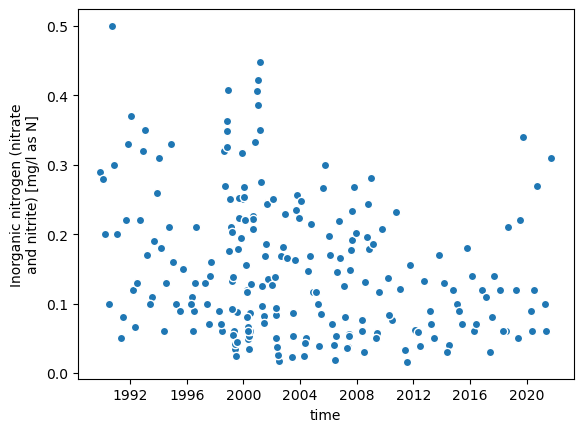

In [5]:
samples.plot.scatter(x="time", y="concentration")

Next, perpare the training data by preforming an inner join of the target and covarites.

In [6]:
from discontinuum.utils import aggregate_to_daily

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join="inner")

Now, we're ready to fit the model. Depending on your hardware, this can take seconds to several minutes. The first fit will also compiles the model, which takes longer. After running it once, try running the cell again and note the difference in wall time.

In [7]:
%%time

from loadest_gp import LoadestGPMarginalPyMC

loadest_model = LoadestGPMarginalPyMC()

# optimizer = pm.adam(learning_rate=.01)

loadest_model.fit(
    target=training_data["concentration"],
    covariates=training_data[["time", "flow"]],
    # method='L-BFGS-B',
)

MAP ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   1% 0:01:14 logp = -146.21, ||grad|| = 0.0077504

CPU times: user 5.16 s, sys: 328 ms, total: 5.49 s
Wall time: 5.27 s


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

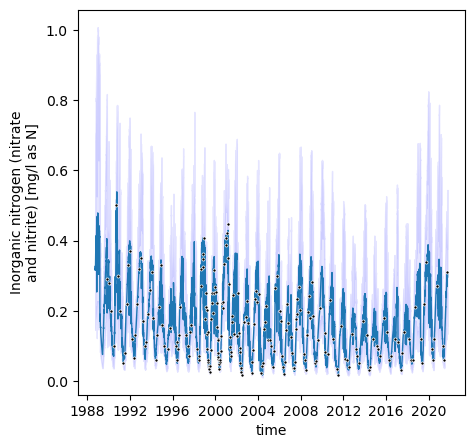

In [8]:
# plot result
loadest_model.plot(daily[["time", "flow"]])

<Axes: xlabel='Year', ylabel='Streamflow [cubic meters per\nsecond]'>

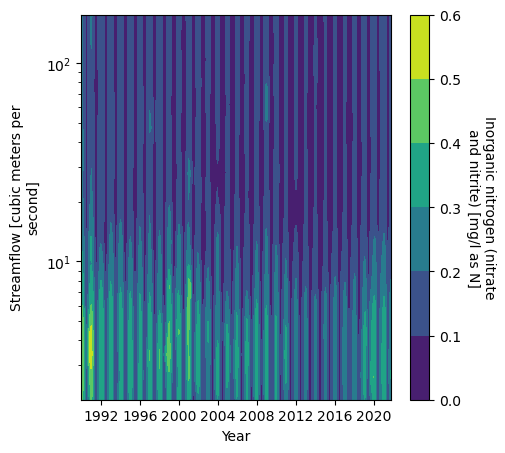

In [9]:
loadest_model.contourf(levels=5, y_scale="log")

In [10]:
# gpytorch debuggin

from loadest_gp import LoadestGPMarginalGPyTorch

model = LoadestGPMarginalGPyTorch()

In [11]:
%%time

model.fit(target=training_data["concentration"], covariates=training_data[["time", "flow"]])

100%|██████████████████| 100/100 [00:00<00:00, 191.43it/s, loss=0.663]


CPU times: user 889 ms, sys: 175 ms, total: 1.06 s
Wall time: 1.05 s


CPU times: user 88.8 ms, sys: 26.3 ms, total: 115 ms
Wall time: 48.2 ms


/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

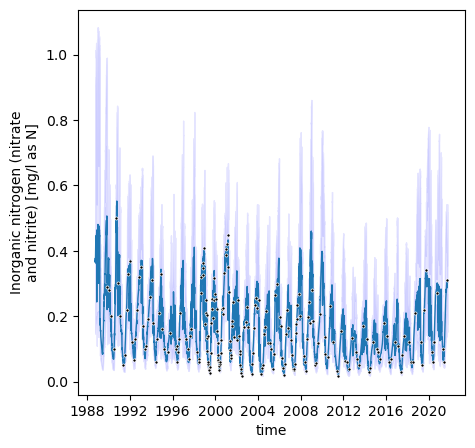

In [12]:
%%time
model.plot(daily[["time", "flow"]])

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


<Axes: xlabel='Year', ylabel='Streamflow [cubic meters per\nsecond]'>

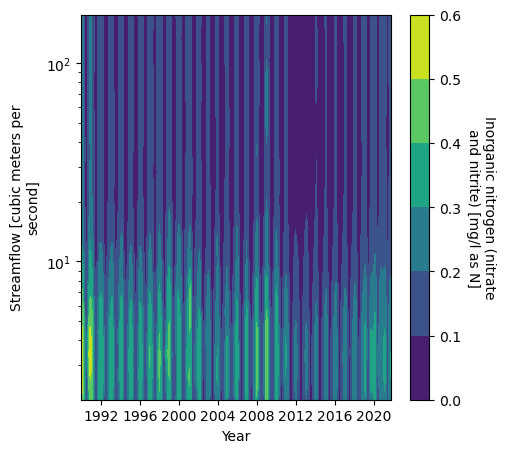

In [13]:
model.contourf(levels=5, y_scale="log")

In [14]:
model.model.train()
model.likelihood.train()

FixedNoiseGaussianLikelihood(
  (noise_covar): FixedGaussianNoise()
)

In [16]:
%%time
# simulate concentration
sim_slice = daily[["time", "flow"]].sel(time=slice("1990", "2020"))

sim = model.sample(sim_slice)

CPU times: user 5.62 s, sys: 1.24 s, total: 6.87 s
Wall time: 4.04 s


In [17]:
# gpytorch
import math

import gpytorch
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# We will use the simplest form of GP model, exact inference
from gpytorch.kernels import MaternKernel, PeriodicKernel, RBFKernel, ScaleKernel
from gpytorch.priors import GammaPrior, HalfNormalPrior, NormalPrior


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.build_model()

    def build_model(self):
        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = self.cov_trend() + self.cov_period() + self.cov_covariates() + self.cov_residual()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def cov_period(self):
        # TODO add priors
        period = NormalPrior(loc=1, scale=0.01)

        return ScaleKernel(
            PeriodicKernel(period_length_prior=period, active_dims=(0)) * MaternKernel(nu=2.5, active_dims=(0)),
            # outputscale_prior=eta
        )

    def cov_trend(self):
        eta = HalfNormalPrior(scale=1)
        ls = GammaPrior(concentration=4, rate=1)

        return ScaleKernel(
            RBFKernel(
                activce_dims=(0),
                lengthscale_prior=ls,
            ),
            outputscale_prior=eta,
        )

    def cov_covariates(self):
        eta = HalfNormalPrior(scale=2)
        ls = GammaPrior(concentration=2, rate=3)  # alpha, beta

        return ScaleKernel(
            RBFKernel(
                lengthscale_prior=ls,
                active_dims=(1),
            ),
            outputscale_prior=eta,
        )

    def cov_residual(self):
        eta = HalfNormalPrior(scale=0.2)
        ls = GammaPrior(concentration=2, rate=10)

        return ScaleKernel(
            MaternKernel(
                ard_num_dims=2,
                nu=1.5,
                active_dims=(0, 1),
                lengthscale_prior=ls,
            ),
            outputscale_prior=eta,
        )

In [19]:
# scale = 1
# X = loadest_model.X.copy()
# X[:,1] = X[:,1]* scale
# X[:,0] = X[:,0]
# y = loadest_model.y * scale
# X[:,0] = X[:,0] - 1989

In [20]:
# loadest_model.X

In [21]:
# initialize likelihood and model
dtype = torch.float
train_x = torch.tensor(loadest_model.X, dtype=dtype)  # dtype=float32 much faster but unstable?
train_y = torch.tensor(loadest_model.y, dtype=dtype)

# noise_prior = NormalPrior(loc=0.02, scale=0.001)
noise_prior = HalfNormalPrior(scale=0.01)
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=noise_prior)
model = ExactGPModel(train_x, train_y, likelihood)

In [22]:
# run on gpu
# No! cholesky not yet implemented on mps
# train_x = train_x.to('mps')
# train_y = train_y.to('mps')
# model = model.to('mps')
# likelihood = likelihood.to('mps')

In [27]:
%%time
# this is for running the notebook in our testing framework
import os

from tqdm import tqdm

smoke_test = "CI" in os.environ
training_iter = 2 if smoke_test else 100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in tqdm(range(training_iter), ncols=70):
    # for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    # print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    #model.covar_module.base_kernel.lengthscale.item(),
    #    model.likelihood.noise.item()
    # ))
    optimizer.step()

100%|██████████████████████████████| 100/100 [00:00<00:00, 155.96it/s]

CPU times: user 793 ms, sys: 249 ms, total: 1.04 s
Wall time: 643 ms


In [28]:
# Xnew = loadest_model.dm.Xnew(daily[['time','flow']]).copy()
# Xnew[:,0] = Xnew[:,0] - 1989

test_x = torch.tensor(loadest_model.dm.Xnew(daily[["time", "flow"]]), dtype=dtype)

In [29]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

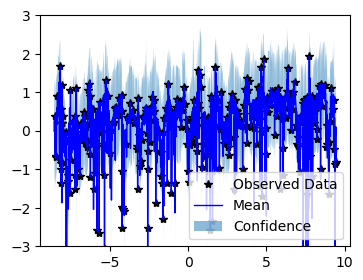

In [30]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x[:, 0].numpy(), train_y.numpy(), "k*")
    # Plot predictive means as blue line
    ax.plot(test_x[:, 0].numpy(), observed_pred.mean.numpy(), "b", lw=1)
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x[:, 0].numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(["Observed Data", "Mean", "Confidence"])

In [31]:
# Clear the cache from the previous computations
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(100):
    start_time = time.time()
    preds = model(test_x)
    fast_time_no_cache = time.time() - start_time

NameError: name 'time' is not defined

In [803]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    start_time = time.time()
    preds = likelihood(model(test_x))
    fast_covar = preds.covariance_matrix
    fast_time_with_cache = time.time() - start_time

In [804]:
print("Time to compute mean + covariances (no cache) {:.2f}s".format(fast_time_no_cache))
print("Time to compute mean + variances (cache): {:.2f}s".format(fast_time_with_cache))

Time to compute mean + covariances (no cache) 0.18s
Time to compute mean + variances (cache): 1.34s


In [726]:
# compute sample yields runtime error

In [805]:
import time

num_samples = 20 if smoke_test else 1000

# Clear the cache from the previous computations
model.train()
likelihood.train()


# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    start_time = time.time()
    exact_samples = model(test_x).rsample(torch.Size([num_samples]))
    exact_sample_time = time.time() - start_time

print(f"Time to compute exact samples: {exact_sample_time:.2f}s")

Time to compute exact samples: 3.23s


In [806]:
# Clear the cache from the previous computations
model.train()
likelihood.train()

# Set into eval mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_root_decomposition_size(200):
    # NEW FLAG FOR SAMPLING
    with gpytorch.settings.fast_pred_samples():
        start_time = time.time()
        _ = model(test_x).rsample(torch.Size([num_samples]))
        fast_sample_time_no_cache = time.time() - start_time

# Repeat the timing now that the cache is computed
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    with gpytorch.settings.fast_pred_samples():
        start_time = time.time()
        love_samples = model(test_x).rsample(torch.Size([num_samples]))
        fast_sample_time_cache = time.time() - start_time

print("Time to compute LOVE samples (no cache) {:.2f}s".format(fast_sample_time_no_cache))
print("Time to compute LOVE samples (cache) {:.2f}s".format(fast_sample_time_cache))

Time to compute LOVE samples (no cache) 5.36s
Time to compute LOVE samples (cache) 3.21s


In [807]:
model.covar_module.kernels[3].base_kernel.lengthscale

tensor([[0.0367, 0.0232]], grad_fn=<SoftplusBackward0>)

In [808]:
model.covar_module.kernels[0].base_kernel.lengthscale

tensor([[2.6105]], grad_fn=<SoftplusBackward0>)

Like WRTDS, we can also plot the variable space:

In [809]:
model.covar_module.kernels

ModuleList(
  (0): ScaleKernel(
    (base_kernel): RBFKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): HalfNormalPrior()
    (raw_outputscale_constraint): Positive()
  )
  (1): ScaleKernel(
    (base_kernel): ProductKernel(
      (kernels): ModuleList(
        (0): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (period_length_prior): NormalPrior()
          (raw_period_length_constraint): Positive()
        )
        (1): MaternKernel(
          (raw_lengthscale_constraint): Positive()
        )
      )
    )
    (raw_outputscale_constraint): Positive()
  )
  (2): ScaleKernel(
    (base_kernel): RBFKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): HalfNormalPrior()
    (raw_outputscale_constraint): Positive()
  )
  (3): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
 

For plotting, we don't need to simulate the full covariance matrix. Instead, we can use its diagonal to compute confidence intervals, but for most other uses, we need to simulate predictions using full covariance, which is slower. Here, we simulate daily concentration during 1990-2020, then we will use those simulations to estimate annual fluxes with uncertainty.

In [72]:
# simulate concentration
sim_slice = daily[["time", "flow"]].sel(time=slice("1990", "2020"))

sim = model.sample(sim_slice)

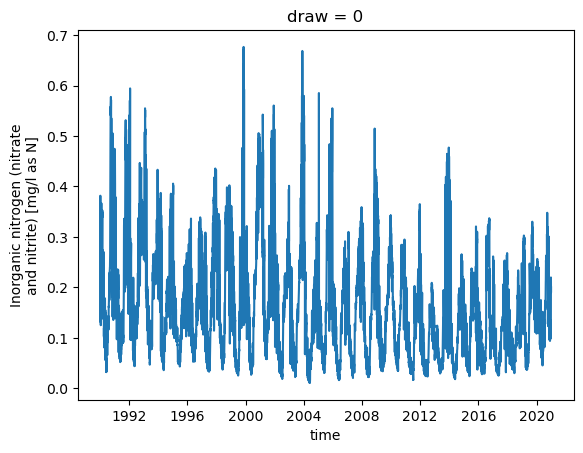

In [73]:
# plot the first realization of concentration.
sim.sel(draw=0).plot.line(x="time")

Before using this simulation, create helper functions to compute flux and plot the results.

In [74]:
# helper functions to compute flux and plot annual fluxes
def to_flux(concentration, flow):
    """Convert concentration and daily mean flow to flux"""
    flux = concentration * flow * 86400 * 1e-6
    flux.attrs = sim.attrs
    flux.attrs["units"] = "kilograms per day"
    flux.attrs["standard_name"] = "flux"
    return flux


def plot_annual_sum(sim):
    """Describe"""
    fig, ax = plt.subplots()
    annual = sim.resample(time="YE").sum()
    annual.attrs["units"] = "kilograms per year"

    annual.to_dataframe(name=annual.attrs["standard_name"]).boxplot(by="time", showfliers=False, grid=False, ax=ax)
    ax.set_ylabel("{}\n[{}]".format(annual.attrs["long_name"], annual.attrs["units"]))
    ax.set_xlabel("Year")
    ax.tick_params(axis="x", labelrotation=90)

    labels = ["" if (year % 5 != 0) else year for i, year in enumerate(annual.time.dt.year.values)]
    ax.set_xticklabels(labels)
    ax.set_title("")
    # fig.suptitle('')
    return ax

Using the helpers, compute and plot the annual flux.

<Axes: xlabel='Year', ylabel='Inorganic nitrogen (nitrate and nitrite)\n[kilograms per year]'>

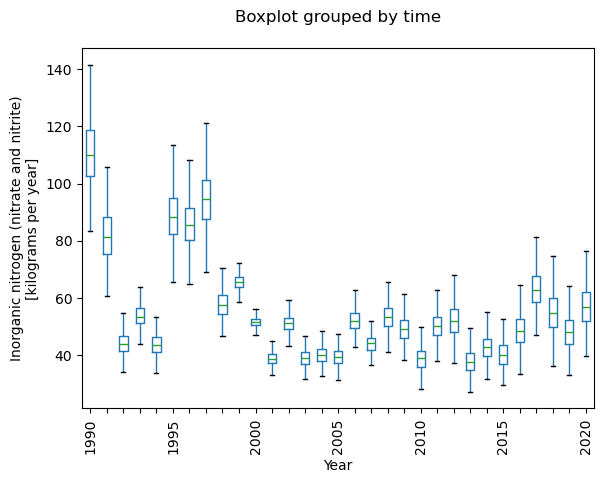

In [75]:
flux = to_flux(sim, sim_slice["flow"])
plot_annual_sum(flux)

In most streams, flow varies substantially from year-to-year, 
and we'd like to know what the flux might have been had flow been constant. 
In causal paralance, this is refered to as a [counterfactual](https://en.wikipedia.org/wiki/Counterfactual_conditional). 
However,`loadest_gp` isn't a causal model and can't provide us with counterfactuals. 
In other words, it can interpolate but not extrapolate. 
Nevertheless, we may treat is as such causal model and see what happens.
Think of this type of analysis as a pseudo-counterfactual or educated guessing.
There area variety of strategies that we might employee, 
some more sophisticated then others. 
At the end of the day, remember we're only guessing, 
so keep it simple and don't be tempted into over-interpretation.
Here, we'll use a simple time substitution.
Pick one year's worth of data and repeat it (except for the time variable) over the entire period of analysis.
For example, let's repeat the year 2005 to fill in the data for our 1990-2020 in our counterfactual.
What's special about 2005?
Nothing, except that it is at the middle of our period.

In [76]:
# create the pseudo-counterfactual
from discontinuum.utils import time_substitution

counterfactual = time_substitution(sim_slice, interval=slice("2005", "2005"))

In [77]:
# simulate
counterfactual_sim = model.sample(counterfactual)
counterfactual_flux = to_flux(counterfactual_sim, sim_slice["flow"])

<Axes: xlabel='Year', ylabel='Inorganic nitrogen (nitrate and nitrite)\n[kilograms per year]'>

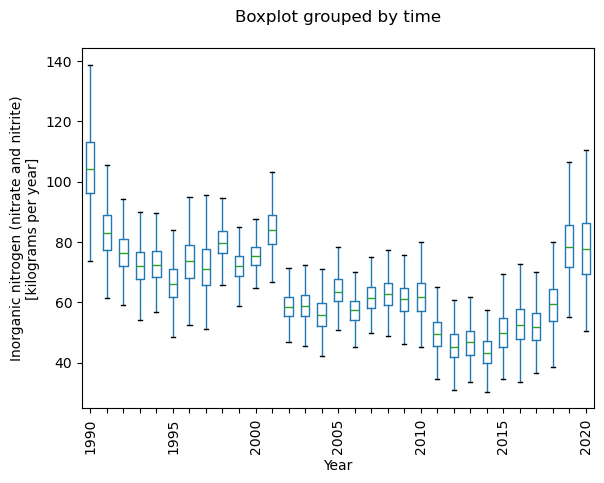

In [78]:
# and plot the result
plot_annual_sum(counterfactual_sim)

Now, the annual fluxes are much less variable than before.

In [65]:
import gpytorch
import torch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [73]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel() + gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [78]:
# this is for running the notebook in our testing framework
import os

smoke_test = "CI" in os.environ
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print(
        "Iter %d/%d - Loss: %.3f"
        % (
            i + 1,
            training_iter,
            loss.item(),
        )
    )
    optimizer.step()

Iter 1/50 - Loss: 0.917
Iter 2/50 - Loss: 0.883
Iter 3/50 - Loss: 0.847
Iter 4/50 - Loss: 0.806
Iter 5/50 - Loss: 0.761
Iter 6/50 - Loss: 0.714
Iter 7/50 - Loss: 0.666
Iter 8/50 - Loss: 0.621
Iter 9/50 - Loss: 0.579
Iter 10/50 - Loss: 0.541
Iter 11/50 - Loss: 0.505
Iter 12/50 - Loss: 0.470
Iter 13/50 - Loss: 0.436
Iter 14/50 - Loss: 0.401
Iter 15/50 - Loss: 0.367
Iter 16/50 - Loss: 0.332
Iter 17/50 - Loss: 0.297
Iter 18/50 - Loss: 0.262
Iter 19/50 - Loss: 0.227
Iter 20/50 - Loss: 0.193
Iter 21/50 - Loss: 0.160
Iter 22/50 - Loss: 0.128
Iter 23/50 - Loss: 0.097
Iter 24/50 - Loss: 0.068
Iter 25/50 - Loss: 0.041
Iter 26/50 - Loss: 0.017
Iter 27/50 - Loss: -0.005
Iter 28/50 - Loss: -0.023
Iter 29/50 - Loss: -0.038
Iter 30/50 - Loss: -0.050
Iter 31/50 - Loss: -0.059
Iter 32/50 - Loss: -0.066
Iter 33/50 - Loss: -0.072
Iter 34/50 - Loss: -0.075
Iter 35/50 - Loss: -0.077
Iter 36/50 - Loss: -0.076
Iter 37/50 - Loss: -0.074
Iter 38/50 - Loss: -0.071
Iter 39/50 - Loss: -0.067
Iter 40/50 - Loss: -0

In [174]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [175]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [178]:
train_x = train_x.to("mps")
train_y = train_y.to("mps")
model = model.to("mps")
likelihood = likelihood.to("mps")

In [36]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 50
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print("Iter %d/%d - Loss: %.3f noise: %.3f" % (i + 1, training_iter, loss.item(), model.likelihood.noise.item()))
    optimizer.step()

AttributeError: 'LoadestGPMarginalGPyTorch' object has no attribute 'train'

In [8]:
from loadest_gp import LoadestGPMarginalGPyTorch

In [9]:
model = LoadestGPMarginalGPyTorch()

In [10]:
model.fit(target=training_data["concentration"], covariates=training_data[["time", "flow"]])

/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/models/gpytorch.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(X, dtype=torch.float32)
/Users/thodson/Desktop/dev/software/discontinuum/src/loadest_gp/models/gpytorch.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(y, dtype=torch.float32)


AttributeError: 'LoadestGPMarginalGPyTorch' object has no attribute 'torch'

In [14]:
%debug

> /Users/thodson/Desktop/dev/software/discontinuum/src/discontinuum/engines/gpytorch.py(64)fit()
     62         # preprocessing: setup data manager
     63         self.build_datamanager()
---> 64         self.dm.fit(target=target, covariates=covariates)
     65 
     66         self.X = self.dm.X



ipdb>  l


     59             Optimization method. The default is "adam".
     60         """
     61         self.is_fitted = True
     62         # preprocessing: setup data manager
     63         self.build_datamanager()
---> 64         self.dm.fit(target=target, covariates=covariates)
     65 
     66         self.X = self.dm.X
     67         self.y = self.dm.y
     68         train_x = torch.tensor(self.X, dtype=torch.float32)
     69         train_y = torch.tensor(self.y, dtype=torch.float32)



ipdb>  type(self.dm)


<class 'NoneType'>


ipdb>  self.build_datamanager()
ipdb>  self.dm
ipdb>  c
